<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2_Silica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

In [65]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
sns.set_theme(color_codes=True)
%matplotlib inline

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

In [48]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation_grouped.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [49]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to  0.17 Mb (50.0% reduction)


##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [50]:
round(flotation.describe(),3).T

,count,mean,std,min,25%,50%,75%,max
iron_feed,4097.0,56.295,5.158,42.740,52.670,56.080,59.720,65.780
silica_feed,4097.0,14.652,6.808,1.310,8.940,13.850,19.600,33.400
starch_flow,4097.0,338.146,92.677,102.567,283.587,335.505,382.469,963.312
amina_flow,4097.0,488.161,83.694,242.927,436.038,502.454,549.522,736.982
pulp_flow,4097.0,397.576,8.370,376.838,398.849,399.841,400.582,418.070
pulp_pH,4097.0,9.768,0.378,8.750,9.541,9.796,10.031,10.810
pulp_density,4097.0,1.680,0.064,1.520,1.651,1.696,1.722,1.833
airflow,4097.0,288.657,18.520,221.602,278.442,299.805,299.976,316.005
level,4097.0,467.252,74.329,340.585,399.869,456.895,514.547,745.230
iron_conc,4097.0,65.050,1.118,62.050,64.370,65.210,65.860,68.010


- Iron Feed: The iron feed values range from 42.74 to 65.78 with a mean of 56.295. The standard deviation indicates moderate variability in the data.

- Silica Feed: The silica feed values range from 1.31 to 33.4 with a mean of 14.652. The data shows a wider range and higher variability compared to the iron feed.

- Starch Flow: The starch flow values range from 102.567 to 963.312 with a mean of 338.146. There is a considerable range in values, indicating significant variability in starch flow.

- Amina Flow: The amina flow values range from 242.927 to 736.982 with a mean of 488.161. The data shows moderate variability.

- Pulp Flow: The pulp flow values range from 376.838 to 418.07 with a mean of 397.576. The data indicates relatively low variability.

- Pulp pH: The pulp pH values range from 8.75 to 10.81 with a mean of 9.768. The data shows moderate variability.

- Pulp Density: The pulp density values range from 1.52 to 1.833 with a mean of 1.68. The data indicates moderate variability.

- Airflow: The airflow values range from 221.602 to 316.005 with a mean of 288.657. The data shows moderate variability.

- Level: The level values range from 340.585 to 745.23 with a mean of 467.252. The data indicates moderate variability.

- Iron Concentrate: The iron concentrate values range from 62.05 to 68.01 with a mean of 65.05. The data shows relatively low variability.

- Silica Concentrate: The silica concentrate values range from 0.6 to 5.53 with a mean of 2.327. The data shows higher variability compared to the iron concentrate.

In [51]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow,level,iron_conc,silica_conc
iron_feed,1.000000,-0.971833,-0.012753,-0.096215,0.186379,0.007458,-0.136404,-0.080216,0.028466,0.055454,-0.077114
silica_feed,-0.971833,1.000000,0.029140,0.085890,-0.174834,0.008383,0.113417,0.107268,-0.049391,-0.044189,0.072782
starch_flow,-0.012753,0.029140,1.000000,0.039488,0.047801,0.230099,-0.118724,0.143422,-0.097972,0.035205,-0.043536
amina_flow,-0.096215,0.085890,0.039488,1.000000,0.237586,0.134163,0.659765,0.131672,-0.324536,-0.120416,0.171142
pulp_flow,0.186379,-0.174834,0.047801,0.237586,1.000000,0.138802,0.019916,-0.181273,-0.030256,0.096595,0.009619
pulp_pH,0.007458,0.008383,0.230099,0.134163,0.138802,1.000000,0.122639,0.182103,-0.121504,0.197962,-0.151422
pulp_density,-0.136404,0.113417,-0.118724,0.659765,0.019916,0.122639,1.000000,-0.023721,-0.148443,0.016802,0.050825
airflow,-0.080216,0.107268,0.143422,0.131672,-0.181273,0.182103,-0.023721,1.000000,-0.461957,0.050338,-0.165113
level,0.028466,-0.049391,-0.097972,-0.324536,-0.030256,-0.121504,-0.148443,-0.461957,1.000000,0.072211,-0.078572
iron_conc,0.055454,-0.044189,0.035205,-0.120416,0.096595,0.197962,0.016802,0.050338,0.072211,1.000000,-0.801212


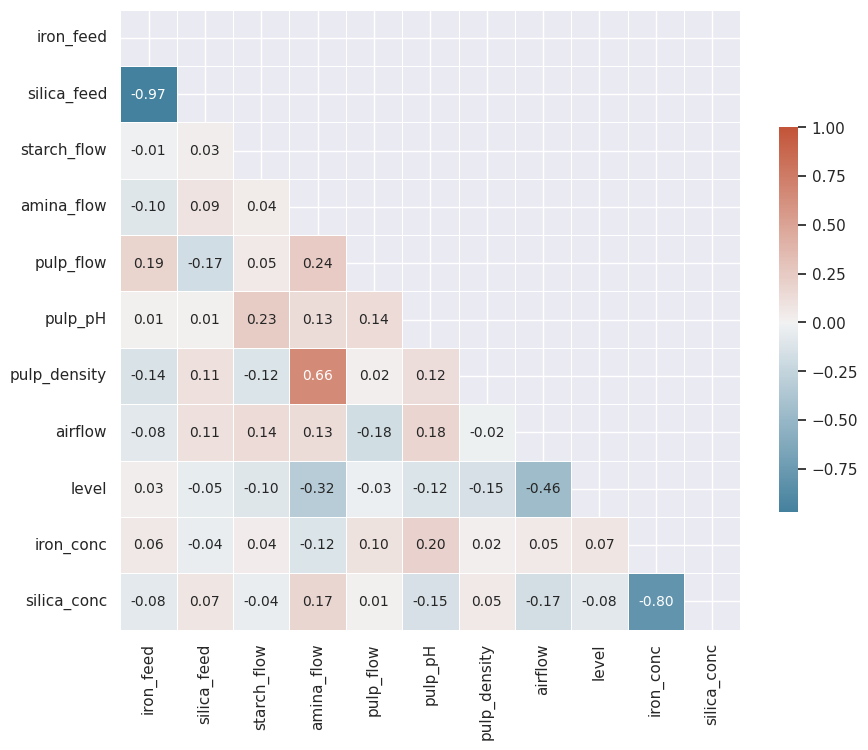

In [52]:
# Correlation Heatmap
f, ax = plt.subplots(figsize=(10, 10))
mat = flotation.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, 
            center=0, annot = True, square=True, 
            linewidths=.5, annot_kws={"fontsize": 10}, 
            cbar_kws={"shrink": .5}, fmt='.2f')
plt.show()

Correlation between the target variables (silica concentrate and iron concentrate) and features:

**Silica Concentrate** has a weak positive correlation with pulp pH (0.072782), suggesting that higher pulp pH values may be associated with higher silica concentrate levels.
It has a weak negative correlation with airflow (-0.077114), indicating that higher airflow may be associated with lower silica concentrate levels.
Other variables such as iron feed, starch flow, amina flow, pulp flow, pulp density, level, and iron concentrate have correlations with silica concentrate close to zero, indicating a lack of significant linear relationship.

**Iron Concentrate** has a strong negative correlation with silica concentrate (-0.801212), indicating an inverse relationship between the two target variables. This implies that as the iron concentrate increases, the silica concentrate tends to decrease, and vice versa.
It has a weak positive correlation with pulp pH (0.197962), suggesting that higher pulp pH values may be associated with higher iron concentrate levels.
Iron Concentrate has weak correlations close to zero with the other features, including iron feed, silica feed, starch flow, amina flow, pulp flow, pulp density, airflow, and level.
Overall, the correlation analysis suggests that the target variables, silica concentrate and iron concentrate, have relatively weak correlations with the other nine features. The most notable correlation is the strong negative correlation between silica concentrate and iron concentrate, indicating an inverse relationship between them. 

### **5.2. Target Variable (Silica) Statistics**

**Histogram of Silica Concentrate**

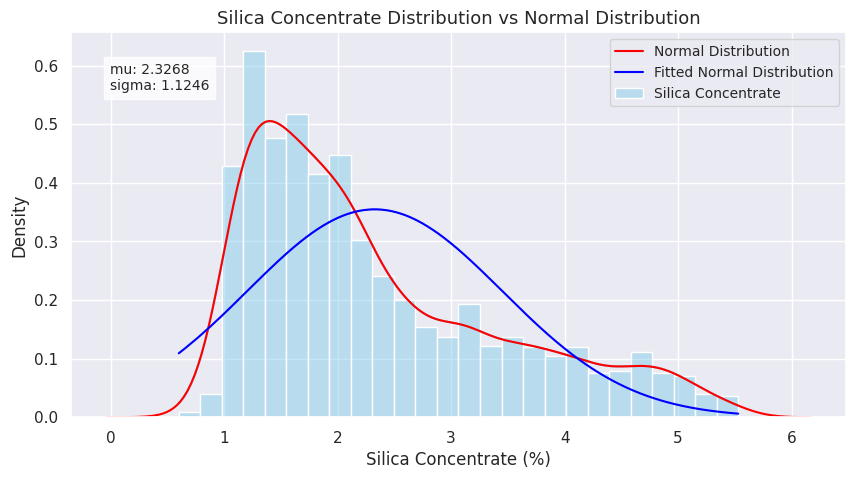

In [53]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(10, 5))
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False,
color='skyblue', label='Silica Concentrate')
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma),
color='blue', label='Fitted Normal Distribution')

plt.text(0.05, 0.85, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.title('Silica Concentrate Distribution vs Normal Distribution', fontsize=13)
plt.xlabel("Silica Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.show()

- mu = 2.3268 indicates that, on average, the Silica Concentrate percentage is around 2.33%. 
- sigma = The standard deviation of 1.1246 suggests that the data points are dispersed around the mean, with a typical deviation of approximately 1.12%.

- The histogram and KDE plot show the distribution of the actual data, while the red curve represents the fitted normal distribution.
- The blue line represents the line plot of the fitted normal distribution, providing a visual representation of how well the normal distribution fits the data.

**Skewness and Kurtosis**

In [54]:
t,p = stats.shapiro(flotation['silica_conc'])

print("Skewness: %f" % abs(flotation['silica_conc']).skew())
print("Kurtosis: %f" % abs(flotation['silica_conc']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: 0.967455
Kurtosis: -0.015312
Shapiro_Test of t: 0.894797
Shapiro_Test of p: 0.000000


- The skewness of 0.967455 indicates that the distribution of the silica concentrate data is positively skewed. This means that the tail of the distribution is skewed towards higher values, and the majority of the data points are concentrated towards the lower end.

- The kurtosis of -0.015312 suggests that the distribution of the silica concentrate data has slightly lower kurtosis than a normal distribution. Negative kurtosis indicates that the distribution has lighter tails and is less peaked compared to a normal distribution. However, the kurtosis value is close to zero, suggesting that the data is approximately normally distributed in terms of its shape.

- The Shapiro-Wilk test of normality resulted in a test statistic of 0.894797 and a p-value of 0.000000. The low p-value indicates that the data significantly deviates from a normal distribution. In other words, the silica concentrate data is not normally distributed.

- The silica concentrate data exhibits positive skewness and slightly lower kurtosis. It departs from a normal distribution, as indicated by the Shapiro-Wilk test. These characteristics should be considered when analyzing the data and choosing appropriate statistical methods or models.

**Fitting the distribution of Silica Concentrate**

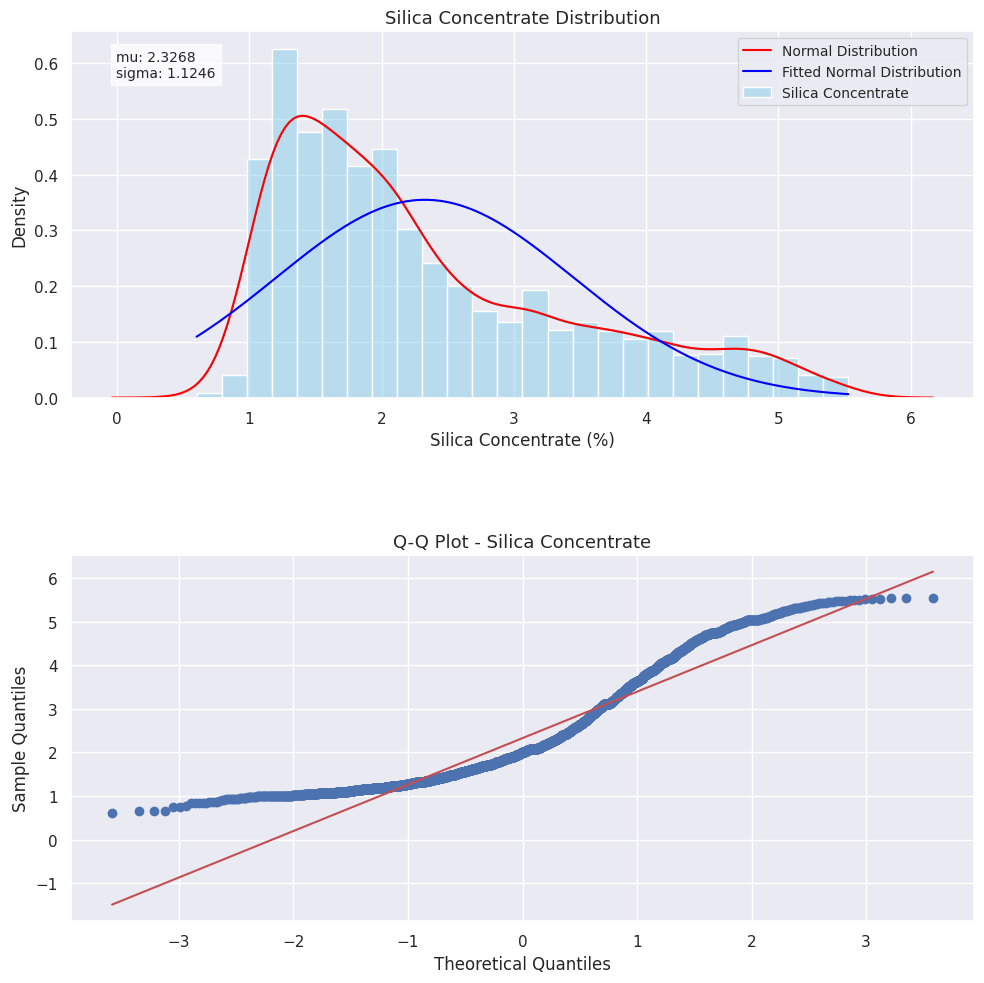

In [55]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False, 
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma), 
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.05, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

axes[0].set_title('Silica Concentrate Distribution', fontsize=13)
axes[0].set_xlabel("Silica Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Q-Q plot
stats.probplot(flotation['silica_conc'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Silica Concentrate", fontsize=13)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

Now let's try to tranform our silica concentration distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see the transformation effect.

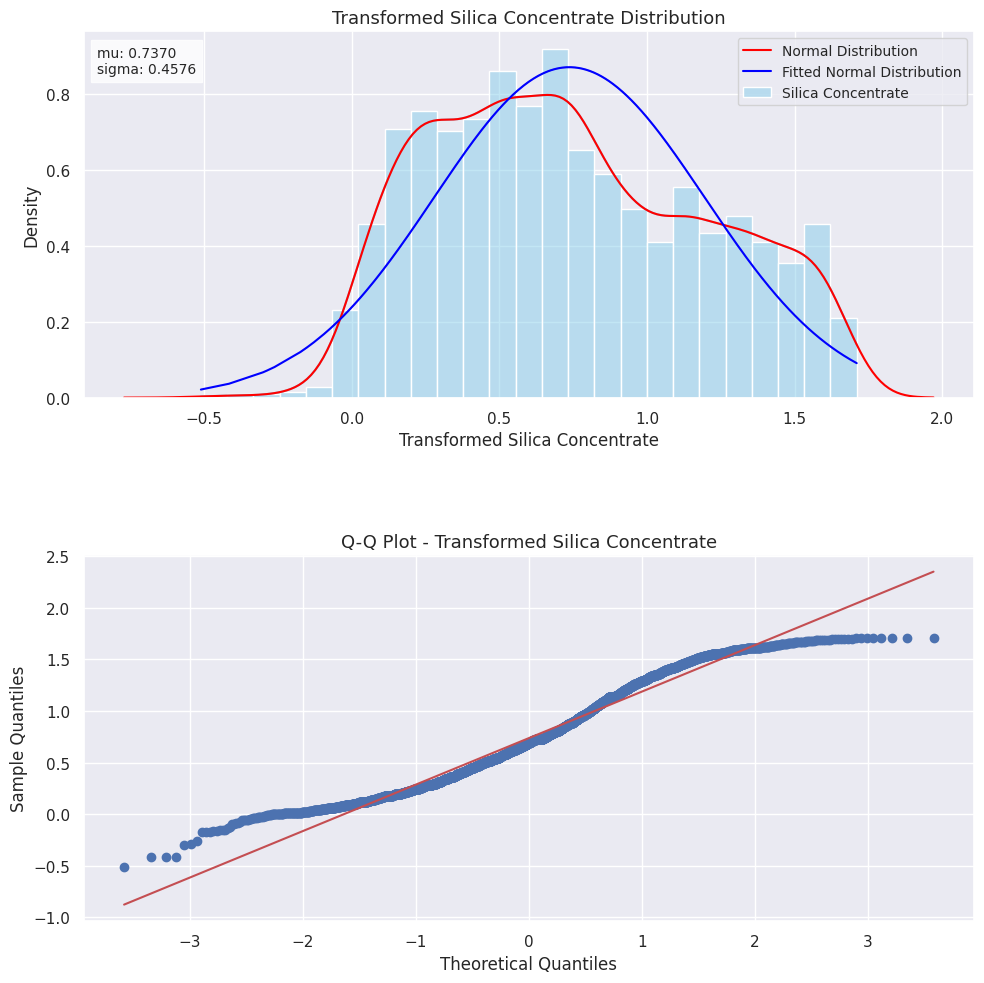

In [56]:
# Log transformation
transformed_conc = np.log(flotation['silica_conc'])

# Fitting normal distribution
(mu, sigma) = norm.fit(transformed_conc)

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False, 
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=transformed_conc, y=norm.pdf(transformed_conc, mu, sigma), 
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Silica Concentrate Distribution', fontsize=13)
axes[0].set_xlabel("Transformed Silica Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[0].text(0.015, 0.96, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Silica Concentrate", fontsize=13)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- **Histogram** shows the distribution of the transformed silica concentrate variable, with the density curve overlaid. The red curve represents a normal distribution fit to the data. The blue line represents the fitted normal distribution curve, which is based on the calculated mean (mu) of 0.7370 and standard deviation (sigma) of 0.4576.

- **Q-Q plot** compares the sample quantiles of the transformed silica concentrate data to the theoretical quantiles of a normal distribution. If the data points fall approximately along the diagonal line, it suggests that the data follows a normal distribution. In this case, the transformed silica concentrate data points align quite well with the diagonal line, indicating that the log-transformed variable approximates a normal distribution.

- According to the histogram, KDE plot, fitted normal distribution curve, and Q-Q plot, the log-transformed silica concentrate variable appears to exhibit a relatively normal distribution. 


**Silica Concentrate vs Iron Concentrate**

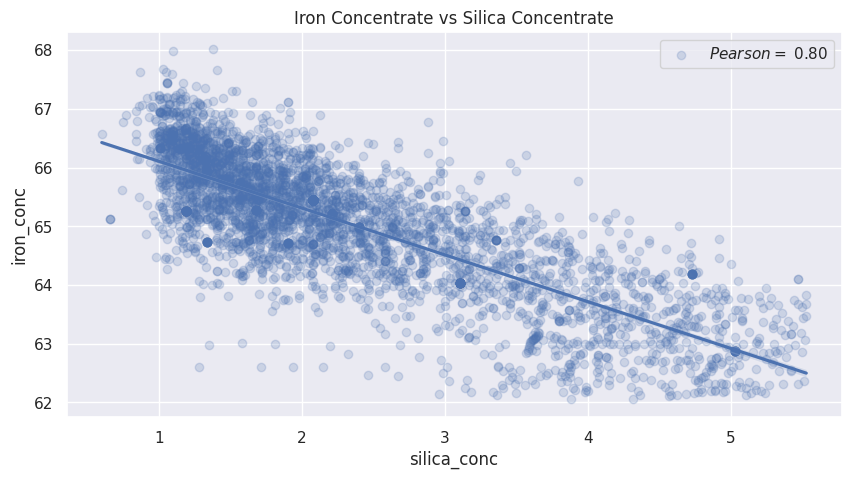

In [57]:
# iron concentrate (target_1) and silica concentrate (target_2) [Pearson = 0.8]

Pearson = 0.80
plt.figure(figsize = (10,5))
sns.regplot(data=flotation, x = 'silica_conc', y='iron_conc', scatter_kws={'alpha':0.2})
plt.title('Iron Concentrate vs Silica Concentrate', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

Scatter plot shows the relationship between Silica Concentrate and Iron Concentrate in the flotation dataset. The Pearson correlation coefficient of -0.80 indicates a strong negative linear correlation between Silica Concentrate and Iron Concentrate in the flotation dataset.

In this case, as the Silica Concentrate increases, there is a tendency for the Iron Concentrate to decrease. This negative correlation suggests that higher levels of Silica Concentrate in the flotation process are associated with lower levels of Iron Concentrate.

While there may be some outliers in the data, the majority of the data points follow the negative correlation trend. This information is valuable in the context of the flotation process as it helps identify the inverse relationship between Silica Concentrate and Iron Concentrate.

Understanding this negative correlation is important for process optimization. It allows for monitoring and controlling Silica Concentrate levels to minimize their impact on Iron Concentrate production. By managing and reducing Silica Concentrate levels, it may be possible to improve the overall quality and yield of Iron Concentrate.

Scatter plot and the strong negative correlation between Silica Concentrate and Iron Concentrate emphasize the need to effectively control Silica Concentrate levels to enhance the production of Iron Concentrate in the flotation process.

## **6. Modelling**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [58]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)
print("Shape of y_Fe:", y_Fe.shape)

Shape of X: (4097, 9)
Shape of y_Si: (4097,)
Shape of y_Fe: (4097,)


**Split (train, validation, test)**

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


### **6.2. MSE - MAE - R^2**

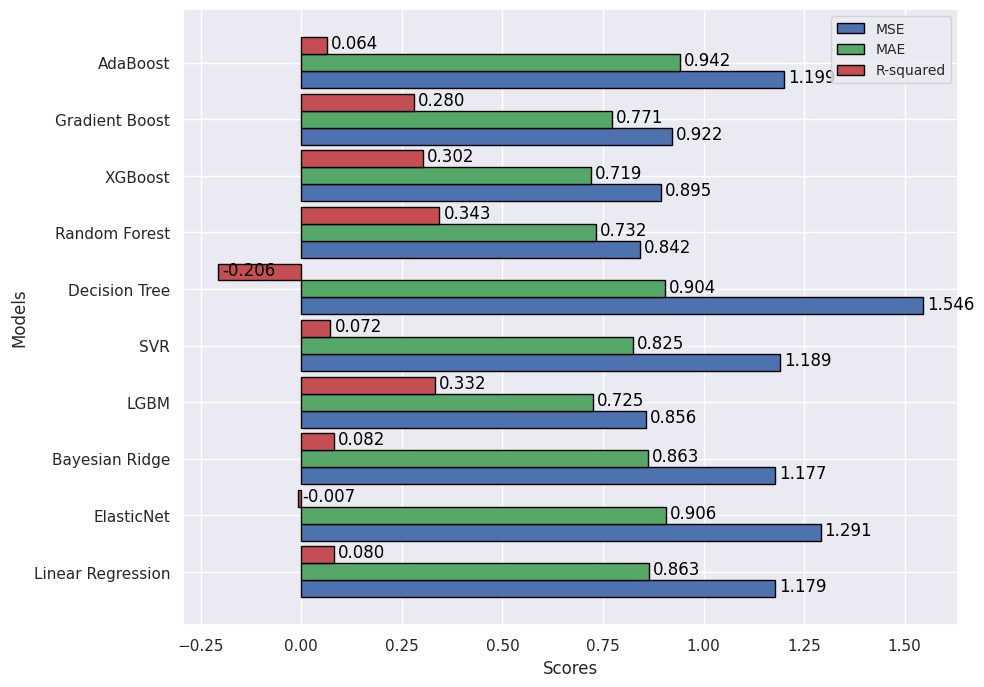

,Model,MSE,MAE,R^2
0,Random Forest,0.841720,0.731737,0.343346
1,LGBM,0.856198,0.725130,0.332051
2,XGBoost,0.895057,0.719164,0.301736
3,Gradient Boost,0.922480,0.771330,0.280342
4,Bayesian Ridge,1.177163,0.862712,0.081655
5,Linear Regression,1.178785,0.863385,0.080389
6,SVR,1.189229,0.824883,0.072242
7,AdaBoost,1.199301,0.942360,0.064384
8,ElasticNet,1.291054,0.905793,-0.007195
9,Decision Tree,1.545792,0.904237,-0.205925


In [60]:
# Define the models and their corresponding names

models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]



mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the validation data
    val_pred = pipeline.predict(X_val)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 8))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], 
           [model_name for _, model_name in models])
plt.legend(loc='upper right', fontsize=10)

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', color='black')
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', color='black')
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', color='black')

plt.show()

# Write the evaluation metric scores
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores})

scores_df = scores_df.sort_values(by='MSE', ascending=True)
scores_df = scores_df.reset_index(drop=True)
scores_df

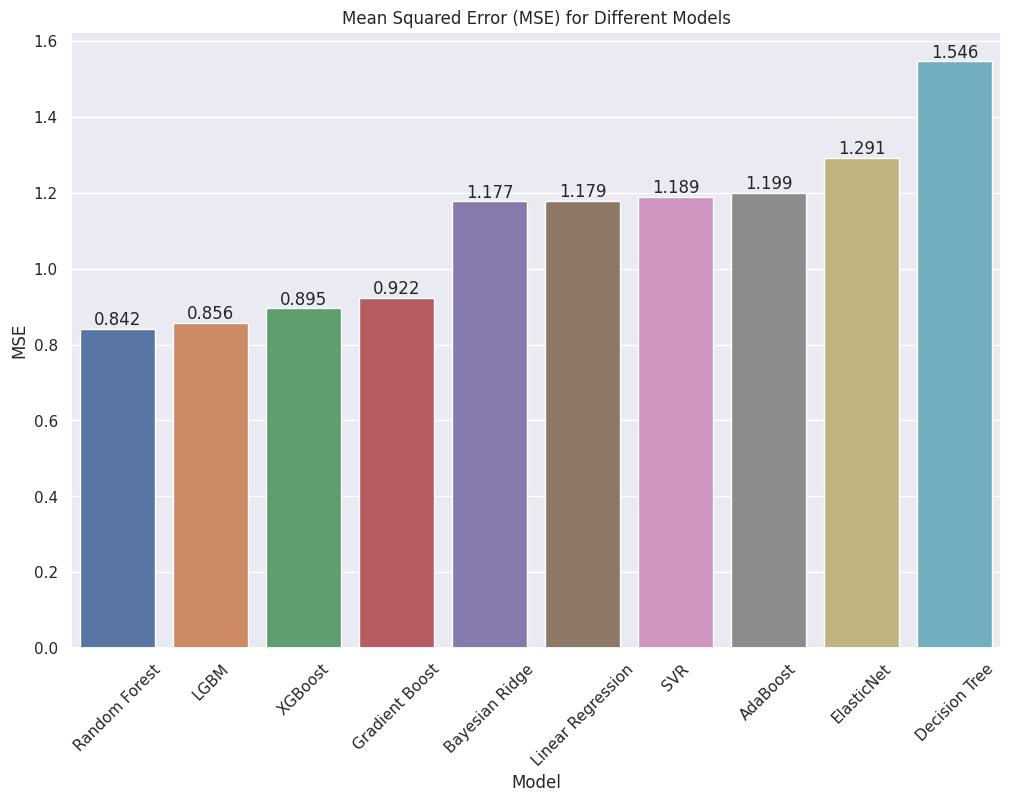

In [61]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='MSE', data=scores_df)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean Squared Error (MSE) for Different Models')

for i, row in scores_df.iterrows():
    plt.text(i, row['MSE'], f'{row["MSE"]:.3f}', ha='center', va='bottom')

plt.show()


- Random Forest: This model has the lowest MSE and highest R^2 score, indicating better overall performance compared to the other models. It also has a relatively low MAE, suggesting good accuracy in predicting the target variable.

- XGBoost: This model performs well with a relatively low MSE and MAE. Although its R^2 score is lower than Random Forest, it still indicates a reasonable level of prediction capability.

- SVM: The Support Vector Machine (SVM) model has a higher MSE, MAE, and lower R^2 compared to the previous models. It may not perform as well as Random Forest and XGBoost in this scenario.

- AdaBoost: The AdaBoost model shows higher MSE, MAE, and lower R^2 compared to the previous models, suggesting relatively poorer performance in predicting the target variable.

- Linear Regression: The simple Linear Regression model performs worse than the ensemble-based models. It has a higher MSE, MAE, and lower R^2, indicating limitations in capturing the complexity of the data.

- ElasticNet: The ElasticNet model performs worse than the linear regression model, as evident from its higher MSE, MAE, and negative R^2 score. It may not be the best choice for this particular dataset.

- Decision Tree: The Decision Tree model has the highest MSE and MAE and the most negative R^2 score. It seems to struggle in capturing the underlying patterns in the data and producing accurate predictions.

- Finally, **the ensemble-based models (Random Forest and XGBoost) perform better than the other models for iron concentrate**. The SVM model also shows some potential but is outperformed by the ensemble models. The linear regression, AdaBoost, ElasticNet, and Decision Tree models exhibit poorer performance.

### **6.3. Cross validation**

- Creation of the RMSE metric

In [62]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, target_log, 
                scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

- 10 Fold Cross validation

In [63]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear', 'Elastic', 'Bayesian Ridge',
                   'LGBM','SVR', 'Decision Tree','Random Forest', 
                   'XGBoost', 'Gradient Boost', 'AdaBoost']

# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

cv_scores = []
cv_std = []

# Perform cross-validation for each model
for model, model_name in models:
    scores = cross_val_score(model, X_train, y_train, 
             scoring='neg_root_mean_squared_error', cv=10)
    cv_scores.append(-scores.mean())
    cv_std.append(scores.std())

# Write the evaluation metric scores
final_cv_score = pd.DataFrame({'Model': [model_name for _, model_name in models],
                               'RMSE_mean': cv_scores,
                               'RMSE_std': cv_std})
final_cv_score = final_cv_score.sort_values(by='RMSE_mean', ascending=True)
final_cv_score = final_cv_score.reset_index(drop=True)
final_cv_score

,Model,RMSE_mean,RMSE_std
0,LGBM,0.905566,0.043904
1,Random Forest,0.921449,0.050105
2,XGBoost,0.938974,0.034829
3,Gradient Boost,0.947726,0.036516
4,Linear Regression,1.046610,0.050226
5,Bayesian Ridge,1.046952,0.051024
6,ElasticNet,1.072216,0.056237
7,AdaBoost,1.080680,0.046592
8,SVR,1.096267,0.061030
9,Decision Tree,1.280987,0.054055


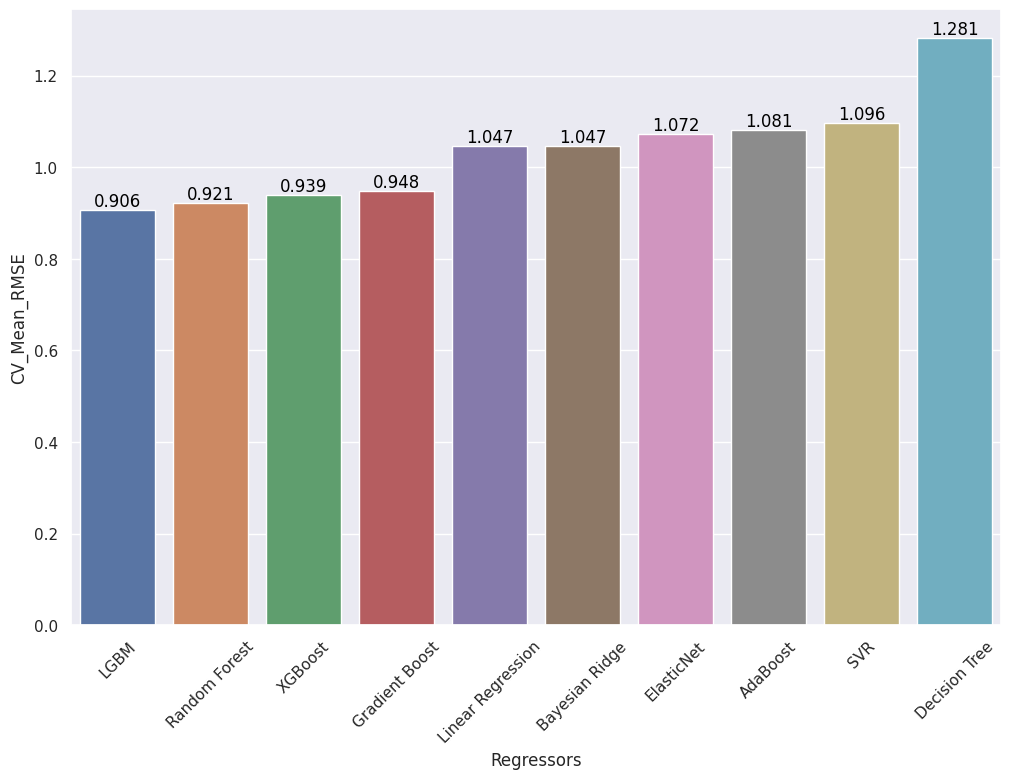

In [64]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)

for i, row in final_cv_score.iterrows():
    plt.text(i, row['RMSE_mean'], f'{row["RMSE_mean"]:.3f}', color='black', ha='center', va='bottom')
    
plt.show()


The evaluation of various regression models was performed using two different approaches:

**Individual Model Evaluation:**

- Ten different regression models were trained and evaluated individually using mean squared error (MSE), mean absolute error (MAE), and R-squared metrics.
- The models considered were Linear Regression, ElasticNet, Bayesian Ridge, LGBM, SVR, Decision Tree, Random Forest, XGBoost, Gradient Boost, and AdaBoost.
- The evaluation results showed that Random Forest and LGBM performed relatively better in terms of MSE, MAE, and R-squared metrics.
- The models at the bottom of the list, such as Decision Tree and ElasticNet, showed relatively poorer performance.


**Cross-Validated Model Evaluation:**

- Ten-fold cross-validation was performed for the same regression models to obtain more robust evaluation metrics.
- The evaluation metric used was root mean squared error (RMSE).
- The cross-validated results showed that LGBM had the lowest RMSE_mean, followed by Random Forest and XGBoost.
- Decision Tree had the highest RMSE_mean among the models considered.
- Based on these evaluations, **LGBM, Random Forest, and XGBoost consistently performed well across both individual and cross-validated evaluations.** These models are likely to be good choices for predicting the target variable in this regression problem.

## **7. Hyperparameter Optimization**

In [66]:
# Define the model
model = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, 
              scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Evaluate the best model on the validation data
val_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 0.848
MAE: 0.731
R^2: 0.339


Best hyperparameters for the RandomForestRegressor model are:

max_depth: None
min_samples_split: 2
n_estimators: 200

These hyperparameters were selected based on the evaluation metric (MSE) and indicate that the model should have unlimited depth (max_depth of None), a minimum of 2 samples required to split an internal node (min_samples_split), and 200 decision trees (n_estimators).

The evaluation metrics for the model with these hyperparameters are: 

MSE: 0.848
MAE: 0.731
R^2: 0.339

Lower value of MSE indicates better performance, and an MSE of 0.848 suggests that the model's predictions have a relatively low average squared difference from the actual values.

Similar to MSE, lower values indicate better performance, and an MAE of 0.731 suggests that the model's predictions have a relatively low average absolute difference from the actual values.

The R^2 score  ranges from 0 to 1, with higher values indicating a better fit. An R^2 score of 0.339 suggests that the model explains approximately 33.9% of the variance in the target variable, indicating a moderate level of predictability.

Overall, RandomForestRegressor model with the optimized hyperparameters shows promising performance based on the evaluation metrics. 

## **8. Submission**

In [77]:
submission = pd.DataFrame(range(1, len(test_pred) + 1), columns=['Id'])
submission['Silica Concentrate'] = np.expm1(test_pred)

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

In [78]:
submission

,Id,Silica Concentrate
0,1,8.755867
1,2,8.061186
2,3,4.265015
3,4,3.516774
4,5,24.214470
...,...,...
405,406,6.599581
406,407,4.645451
407,408,15.236784
408,409,3.414524


### **9. Conclussion**

we performed several steps to develop a regression model for predicting the Silica Concentrate. Here's a summary of the key points:

**Data Preprocessing**: We started by loading the dataset and performing necessary data preprocessing steps. This involved handling missing values, transforming categorical variables, and splitting the data into training and validation sets.

**Model Selection and Evaluation**: We evaluated several regression models, including Linear Regression, ElasticNet, Bayesian Ridge, LGBM, SVR, Decision Tree, Random Forest, XGBoost, Gradient Boost, and AdaBoost. We used evaluation metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared to assess their performance on the validation set.

**Hyperparameter Optimization**: To improve the performance of the models, we performed hyperparameter optimization using GridSearchCV. This allowed us to find the best combination of hyperparameters for the Random Forest model, such as the maximum depth, minimum samples split, and number of estimators.

**Test Submission**: After obtaining the best hyperparameters, we made predictions on the test set using the optimized Random Forest model. We created a submission DataFrame with sequential IDs and the corresponding predicted values for the Silica Concentrate. The DataFrame was saved as a CSV file for submission.

**Discussion**: The optimized Random Forest model achieved a MSE of 0.848, MAE of 0.731, and R-squared of 0.339 on the validation set. These metrics indicate the performance of the model in accurately predicting the Silica Concentrate. The submission DataFrame contains the predicted values for the Silica Concentrate, organized by sequential IDs, ready for submission.

**Finally, the optimized Random Forest model demonstrated relatively good performance in predicting the Silica Concentrate.**